### Imports

In [40]:
import boto3
import dask
import dilib
import os
import pathlib
import pytz
from collections import defaultdict
from datetime import datetime, timedelta
from typing import Any

import pandas as pd
import numpy as np
import rich

from epoch_data import athena
from epoch_data import calendarlib
from epoch_data import hdstorelib
from epoch_infra import commonlib
from epoch_infra import clusterlib
from epoch_infra import joblib
from epoch_markets import symlib
from epoch_markets.mdcatalog.options import data_config, instr_helper, job, job_config
from epoch_markets.symlib import options
from epoch_data import hdstorelib, calendarlib
from epoch_markets import symlib
from epoch_markets.symlib import options, base

from octopus import refdata_options
from octopus import datelib
from octopus import archives

In [41]:
from __future__ import annotations

### Helpers - General

In [42]:
def get_secmaster(path_prefix: str="/fsxcache/output") -> symlib.SecMaster:
    data_client = hdstorelib.MainDataClient(
        protocol="file",
        host=None,
        name_resolver=None,
        network_latency=None,
        path_prefix=path_prefix
    )

    fronts_factory = symlib.FrontsFactory(
        data_client=data_client,
        base_path="secdef",
        front_scheme="mft_rel",
        ignore_missing_products=True,
    )

    secmaster = symlib.SecMaster(
        data_client=data_client,
        base_path="secdef",
        fronts_factory=fronts_factory,        
    )

    return secmaster

secmaster = get_secmaster()


def get_mapping_from_gsym(gsym: str) -> symlib.InstrumentMapping:
    return symlib.InstrumentKey.get_instrument_mapping(gsym)


def get_futures(
    gsym: str,
    trade_date: datetime.date,
) -> list[symlib.Instrument]:
    res = set()
    for offset in range(1, 3):
        key = symlib.InstrumentKey(gsym, trade_date, offset)
        res.add(secmaster.get_instrument(key))
    return list(res)


def get_options(
    gsym: str,
    start_date: datetime.date,
    end_date: datetime.date,
    is_complex: bool,
) -> list[symlib.Instrument]:
    res = []
    for trade_date in calendar.get_date_range(
        start_date, end_date, isoweekdays={1, 2, 3, 4, 5}
    ):
        res.extend(instr_helper.get_options(gsym, trade_date, trade_date, 0, secmaster=secmaster))
    return list(set(res))


def get_exchange_symbols(
    gsym: str,
    trade_date: datetime.date,
    is_complex: bool,
) -> list[str]:
    ids = instr_helper.get_exchange_symbols_and_sec_ids(trade_date, trade_date, calendar, gsym, secmaster=secmaster)
    return [i.exchange_symbol for i in ids]


# read a book parquet file for some symbol
# e.g. data = client.gather(client.compute(dask.delayed(get_book_data)("03Tzyk", calendar.get_date(20230921, forward=True), version)))
def get_book_data(exchange: str, gsym: str, symbol: str, trade_date: calendarlib.TradeDate, version: str):
    # /{fsx_location}/books/cboe/2023/01/03/v5/{symbol}/book.parquet
    args = dict(exchange=exchange, year=trade_date.year, month=trade_date.month_padded, 
                day=trade_date.day_padded, version=version, symbol=symbol, gsym=gsym)
    if exchange == "cme":
        book_location = "/fsxcache/output/books/{exchange}/{gsym}/{year}/{month}/{day}/{version}/{symbol}"
    elif exchange == "cboe":
        book_location = "/fsxcache/output/books/{exchange}/{year}/{month}/{day}/{version}/{symbol}"
    elif exchange == "nymx":
        book_location = "/fsxcache/output/books/{exchange}/{year}/{month}/{day}/{version}/{symbol}"
    path = book_location.format(**args)
    print (path)
    files = ["book", "trades"]
    ret = {}
    for f in files:
        ret[f] = pd.read_parquet(f"{path}/{f}.parquet")
    return ret

def get_outright_1m_price_data_cache_hashes(trade_date: calendarlib.TradeDate, keys: list[symlib.OptionSpecificInstrumentKey]):
    data_context = athena.DataContext(read_namespaces=["prod"], write_namespace="prod")
    container = data_config.get_options_container(data_context=data_context)
    core_market_dataset = container.config.core_market_dataset
    res = {}
    for key in keys:
        if exchange == "cme":
            res[key.exchange_security_id] = core_market_dataset.get_outright_1m_price_data(key, version).cache_protocol.data_hash
        else:
            res[key.exchange_symbol] = core_market_dataset.get_outright_1m_price_data(key, version).cache_protocol.data_hash
        return res

def validate_cached_downsampled_files(gsym: str, trade_date: calendarlib.TradeDate, keys: list[symlib.OptionSpecificInstrumentKey]):
    res_list = []
    cache_hashes = get_outright_1m_price_data_cache_hashes(trade_date, keys)
    for exchange_symbol, cache_hash in cache_hashes.items():
        path = f"/fsxcache/output/prod/derived/options_core_market/v1/outright_1m_price_data/v0/{cache_hash}/{exchange_symbol}/{trade_date}.pickle"
        res = dict(symbol=exchange_symbol, date=trade_date, file_location=path)
        res[f"ds_file_exists"] = os.path.exists(path)
        res_list.append(res)
    return res_list

In [43]:
"""
Relatively standalone arb-checking tools for Zeno.

See the "Arb-Uniform" LP in Joel's Zeno notes for an explanation:
    http://mftshare/joel.gibson/notes_html/Zeno/Arbitrage%20in%20OSPXW%20and%20OESW.html
Although what is done here is slightly different in the treatment of the wings.
"""

from __future__ import annotations

import numpy as np
import scipy.optimize


def create_gross_payoff(strike: np.ndarray, pc_flag: np.ndarray):
    """
    Create a gross payoff matrix of shape (S, A), where S is the number of distrinct strikes in the
    problem, and gross_payoff[i, j] is the payoff of contract j at the ith strike.

    Input are two vectors of the same length A:
    - strike[i] is the strike price of the ith contract.
    - pc_flag[i] is 'C' for calls and 'P' for puts.
    """
    A = len(strike)
    assert strike.shape == pc_flag.shape == (A,)

    # The elbows are the sample points in price space.
    elbow = np.unique(strike)
    E = len(elbow)

    # Convert the put-call flag into +1 for calls, and -1 for puts.
    pc_sign = np.where(pc_flag == 'C', 1.0, -1.0)

    # The payoff matrix has shape (E, 2A), a horizontally-stacked matrix of [buy, sell].
    # The entry [e, a] is the payoff for buying the ath contract, if the underlying finishes at e.
    # The entry [e, A + a] is the payoff for selling.
    # Add a dummy column at the end for t.
    payoff = np.zeros((E, A), dtype=float)
    for i in range(A):
        payoff[:, i] = np.maximum(pc_sign[i] * (elbow - strike[i]), 0.0)

    return payoff


def arb_uniform(
    gross_payoff: np.ndarray,  # (S, A)
    pc_flag: np.ndarray,  # (A)
    bid: np.ndarray,  # (A)
    ask: np.ndarray,  # (A)
) -> tuple[float, np.ndarray, np.ndarray]:  # (1, (A), (A))
    """
    Check a collection of option prices (of length A) for arbitrage, at a single point in time.

    Inputs:
    - gross_payoff: Shape (S, A) representing payoffs at strikes.
    - pc_flag: Shape (A), either 'C' for call or 'P' for put.
    - bid, ask: Shape (A), bid and ask prices, or NaN if the price does not exist.

    Returns a pair (payoff, buy_weight, sell_weight) of the maximum uniform payoff (a scalar)
    achievable, and two shape (A) vectors of weights to use to buy/sell to achieve this payoff.
    If the payoff scalar is positive, there is an arbitrage.

    Usually one would expect there to be no cancellation in buy_weight - sell_weight, i.e. if we
    are buying something we don't sell it, and vice-versa. However, since we are forcing the buy
    and sell weights to collectively add to 1, sometimes we are forced to both buy and sell the same
    contract (especially in a dataset of only one contract)!.
    """
    S, A = gross_payoff.shape
    assert pc_flag.shape == bid.shape == ask.shape == (A,)
    assert np.all((pc_flag == 'C') | (pc_flag == 'P'))

    # Our linear program is the following:
    # Maximise min_payoff = [0 | 0 | 1] ⋅ [buy | sell | min_payoff]
    #   Over (2A + 1) variables:
    #                buy ≥ 0, of length A,
    #               sell ≥ 0, of length A,
    #         min_payoff ∈ ℝ, scalar
    #   With the constraints:
    #     L1 (S)  [ gross_payoff - 1 @ askᵀ | 1 @ bidᵀ - gross_payoff | -1 ] @ [buy | sell | t] ≥ 0
    #     L2 (1)  [ call_indicator          | - call_indicator        |  0 ] @ [buy | sell | t] ≥ 0
    #     L3 (1)  [ put_indicator           | - put_indicator         |  0 ] @ [buy | sell | t] ≥ 0
    #     E4 (1)  [ 1 1 1 1 1 1 1 1 1 1 1 1 | 1 1 1 1 1 1 1 1 1 1 1 1 |  0 ] @ [buy | sell | t] = 1
    #
    # Constraint L1 is saying that net_payoff(buy, sell) evaluated at the strike k is ≥ t, for all
    # strikes k. Since the objective is to maximise t, this means at any optimal solution t will be
    # the minimum net payoff at any strike. Constraint L2 says that the gradient of the payoff curve
    # after the largest strike is zero or positive (this gradient is the net weight of calls).
    # Similarly, constraint L3 says that the gradient on the left of the smallest strike is
    # negative, i.e. increases to the left. Finally, constraint E4 forces the weights to sum to 1.
    #
    # There are other details:
    # 1. scipy.optimise.linprog wants to accept a constraint like L @ x ≤ b rather than L @ x ≥ b.
    #    So we end up negating our L matrix.
    # 2. scipy.optimise.linprog wants to minimise instead of maximise. So we negate our objective
    #    vector, and negate the final value of the program as well.
    # 2. Buy variables (and corresponding constraint columns) where the ask are NaN are removed
    #    entirely from the problem, and similarly for missing bid prices.
    #
    # Since buy, sell ≥ 0 and constraint E4, the buy and sell variables are bounded. Hence t is also
    # bounded provided there is at least one nonzero column in L1. If all bids and asks are NaN,
    # then t will be unbounded. So we should early return from this case. Any buy and sell in bounds
    # can be extended to a feasible point by taking t low enough, so the LP is always feasible.

    # Mask of variables: only present buys, present sells, and always t.
    mask = np.concatenate([~np.isnan(ask), ~np.isnan(bid), [True]])
    if mask[:2*A].sum() == 0:
        return 0.0, np.zeros(A, dtype=float), np.zeros(A, dtype=float)

    # Objective function
    obj = np.zeros(2 * A + 1, dtype=float)
    obj[-1] = 1

    # We could construct this a bit at a time or as a block matrix and both ways are gross...
    L = np.zeros((S + 2, 2 * A + 1), dtype=float)

    # L1
    L[0:S, 0:A] += gross_payoff
    L[0:S, 0:A] -= ask
    L[0:S, A:2*A] -= gross_payoff
    L[0:S, A:2*A] += bid
    L[0:S, -1] = -1.0

    # L2
    L[S, 0:A] = np.where(pc_flag == 'C', 1.0, 0.0)
    L[S, A:2*A] = np.where(pc_flag == 'C', -1.0, 0.0)

    # L3
    L[S+1, 0:A] = np.where(pc_flag == 'P', 1.0, 0.0)
    L[S+1, A:2*A] = np.where(pc_flag == 'P', -1.0, 0.0)

    # E4
    E = np.zeros((1, 2 * A + 1))
    E[:, 0:2*A] = 1

    # Run the solver. We disable the presolve since our constraint matrix is small and interesting
    # enough that it can never reduce the problem anyway. (I think the rows are positively indep
    # and so there is no reduction to be done). Unfortunately Scipy will convert this to a sparse
    # matrix and then give it to HiGHS even though it's dense...
    result = scipy.optimize.linprog(
        c=-obj[mask],
        A_ub=-L[:, mask],
        b_ub=np.zeros(S + 2, dtype=float),
        A_eq=E[:, mask],
        b_eq=np.array([1.0]),
        bounds=[(0, None)] * mask[:2*A].sum() + [(None, None)],
        options=dict(presolve=False),
        method='highs-ds',
    )

    # Since the problem is bounded and feasible, this should always succeed.
    assert result.success

    # Unpack the weights from the mask.
    weight = np.zeros(2*A, dtype=float)
    weight[mask[:-1]] = result.x[:-1]

    return -result.fun, weight[:A], weight[A:]

In [44]:
from __future__ import annotations

import pytest
import dataclasses

import numpy as np
import numpy.testing

@dataclasses.dataclass
class OptData:
    pc: str
    strike: float
    bid: float
    ask: float


@pytest.mark.parametrize('insts, expected_payoff', [
    # A one-sided call: the only possible move is to buy it.
    ([OptData('C', 1000.0, np.nan, 3.0)], -3.0),

    # A two-sided call: the best move is to buy half and sell half.
    # (Can't sell more than we buy, else the payoff curve becomes negative somewhere).
    ([OptData('C', 1000.0, 1.0, 3.0)], -1.0),

    # A call and a put at the same strike. These should be independent, so same result as before.
    ([OptData('C', 1000.0, 1.0, 3.0), OptData('P', 1000.0, 1.0, 3.0)], -1.0),

    # Two calls with a short call spread giving an arb. The best choice is to sell the first and
    # buy the second, for a uniform payoff of
    #   Bid(1000) - Ask(1000) - (1020 - 1000) = (23 - 2) - 20 = 1.0
    # Since weights sum to 1, this will be a payoff of 0.5 here.
    ([OptData('C', 1000.0, 23.0, 24.0), OptData('C', 1020.0, 1.0, 2.0)], 0.5),

    # If the first call is worth a little less, the short call spread is not an arb.
    ([OptData('C', 1000.0, 21.0, 24.0), OptData('C', 1020.0, 1.0, 2.0)], -0.5),
])
def test_arb_uniform_option(insts: list[OptData], expected_payoff: float):
    strike = np.array([inst.strike for inst in insts], dtype='float')
    pc_flag = np.array([inst.pc for inst in insts])
    bid = np.array([inst.bid for inst in insts], dtype='float')
    ask = np.array([inst.ask for inst in insts], dtype='float')

    gross_payoff = zeno.arb.create_gross_payoff(strike, pc_flag)
    payoff, buy, sell = zeno.arb.arb_uniform(gross_payoff, pc_flag, bid, ask)

    numpy.testing.assert_allclose(payoff, expected_payoff)
    assert np.all(buy >= 0)
    assert np.all(sell >= 0)
    numpy.testing.assert_allclose(buy.sum() + sell.sum(), 1.0)


### Helpers - Specific

In [45]:
def get_ch_refdata():
    with refdata_options.get_opt_refdata_dao(refdata_options.OptRefdataDao.TABLE_NAME_V2) as dao:
        return dao.get_all_refdata()

In [46]:
def get_secmaster_refdata(gsym: str):
    return pandas.DataFrame()

In [47]:
def get_market_data(trade_date, ch_refdata, base_asset, pcap_ch_table):
    print (f'Getting market data for {trade_date}')
    
    expiry_date = np.datetime64(trade_date)
    refdata_options = ch_refdata[(ch_refdata.base_asset == base_asset) & (ch_refdata.expiry_date == expiry_date)]
    times_begin = refdata_options.expiry_timestamp[0].replace(hour=0, minute=0, second=0).tz_localize('UTC')
    times_end = refdata_options.expiry_timestamp[0].tz_localize('UTC')
    db_archives = archives.ClickArchive(pcap_ch_table)
    pcap_df = (
            db_archives.load_symbols_between_times(
            symbols=refdata_options.symbol.unique(),
            begin=times_begin,
            end=times_end,
            columns=['ask', 'bid', 'mid', 'ask_size', 'bid_size'],
            )
        )
    pcap_df.set_index(['timestamp'], drop=False, inplace=True)
    pcap_df.sort_index(inplace=True)
    return pcap_df

In [48]:
def check_incorrect_data(pcap_df, checks):
    pcap_neg      = pcap_df[(pcap_df.bid < 0) | (pcap_df.ask < 0)]
    pcap_no_nan   = pcap_df.dropna()
    pcap_in_cross = pcap_no_nan[pcap_no_nan.bid >= pcap_no_nan.ask]
    print ('Incorrect data')
    print ('neg:')
    print (pcap_neg)
    print ('cross')
    print (pcap_in_cross)
    checks['incorrect_data_pcap'] = len(pcap_neg.index) + len(pcap_in_cross.index)
    if len(pcap_in_cross.index) > 0:
        checks['options_to_remove'].extend(pcap_in_cross.symbol.unique())

In [49]:
def get_payoffs(data, opt_symbols, times, pcf, gross_payoff):
    mkt_data = {
        col: numpy.array(
            [
                *[
                    data[opt][col].to_numpy()
                    if opt in data
                    else numpy.full(len(times), numpy.nan)
                    for opt in opt_symbols
                ]
            ]
        ).T
        for col in ['ask', 'mid', 'bid', 'ask_size', 'bid_size']
    }
    results = []
    for idx in range(0, len(times)):
        payoff, buy, sell = arb_uniform(gross_payoff, pcf, mkt_data['bid'][idx], mkt_data['ask'][idx])
        results.append(payoff)
    return results

In [50]:
def arb_check(refdata_options, pcap_df, checks, normal_hours_start_local, normal_hours_end_local):
    
    times_begin = refdata_options.expiry_timestamp[0].replace(hour=0, minute=0, second=0).tz_localize('UTC')
    times_end = refdata_options.expiry_timestamp[0].tz_localize('UTC')      
    opt_symbols = refdata_options.symbol.unique()

    print (checks['options_to_remove'])
    for opt in checks['options_to_remove']:
        opt_symbols = np.delete(opt_symbols, np.where(opt_symbols == opt))
        
    point_values = np.array([*list(refdata_options.loc[opt_symbols, 'point_value'])])
    pcf = np.array([*list(refdata_options.loc[opt_symbols, 'pc'])])
    strikes = np.array([*list(refdata_options.loc[opt_symbols, 'strike_price'])])
    gross_payoff = create_gross_payoff(strikes, pcf)
    times = pd.date_range(times_begin, times_end, inclusive='left', freq='1T', name='datetime')
    pcap_data = {
        symbol: frame.drop('symbol', axis='columns').set_index('timestamp').reindex(times)
        for symbol, frame in pcap_df.groupby('symbol', sort=False)
    }
    pcap_results = get_payoffs(pcap_data, opt_symbols, times, pcf, gross_payoff)
    results = pd.DataFrame(
        {'PCAP': pcap_results
        }, index=times)
    ax = results.plot()
    ax.axhline(0, ls='--', color='black', alpha=0.5)

    checks['pcap_arbs_over_0'] = len(results[results.PCAP > 0].PCAP)
    checks['pcap_arbs_very_over_0'] = len(results[results.PCAP > 1.e-6].PCAP)
    
    results_normal_hours = results[(results.index >= normal_hours_start_local) & (results.index <=  normal_hours_end_local)]
    checks['pcap_arbs_over_0_normal_hours'] = len(results_normal_hours[results_normal_hours.PCAP > 0].PCAP)
    checks['pcap_arbs_very_over_0_normal_hours'] = len(results_normal_hours[results_normal_hours.PCAP > 1.e-6].PCAP)
    
    normal_hours_end_local_optim = normal_hours_end_local - pd.Timedelta(hours=1)
    results_optim_hours = results[(results.index >= normal_hours_start_local) & (results.index <=  normal_hours_end_local_optim)]
    checks['pcap_arbs_over_0_optim_hours'] = len(results_optim_hours[results_optim_hours.PCAP > 0].PCAP)
    checks['pcap_arbs_very_over_0_optim_hours'] = len(results_optim_hours[results_optim_hours.PCAP > 1.e-6].PCAP)
    
    
    # Number of arbs after fees
    # For one unit: EPOCH = 64c / point_value - MM =  12c / point_value
    epoch_fees_per_unit = 0.64 / point_values[0]
    mm_fees_per_unit = 0.12 / point_values[0]
    checks['arbs_epoch_after_fees'] = len(results[results.PCAP > epoch_fees_per_unit].PCAP)
    checks['arbs_mm_after_fees'] = len(results[results.PCAP > mm_fees_per_unit].PCAP)

### Refdata secmaster layer

In [51]:
class OptionsRefDataConstants:
    """
    Constants for the options reference data.
    """
    columns = {
        'symbol': str,
        'base_asset': str,
        'underlying_symbol': str,
        'pc': str, # C or P
        'strike_price': float,
        'point_value': int,
        'expiry_date': 'datetime64[ns]',
        'expiry_timestamp': 'datetime64[ns]',
        'exercise_style': str,
        'settlement_type': str,
        'currency': str,
        'exchange': str,
        'timezone': str,
        'source': str,
    }

    refdata = {
        'OESW': {
            'point_value': 50,
            'exercise_style': 'E',
            'settlement_type': 'Future',
            'timezone': 'America/Chicago',
            'exchange': 'CME',
        },
        'OS0': {
            'point_value': 2500,
            'exercise_style': 'E',
            'settlement_type': 'Future',
            'timezone': 'America/Chicago',
            'exchange': 'CME',
        },
        
        'OTY': {
            'point_value': 100000,
            'exercise_style': 'E',
            'settlement_type': 'Future',
            'timezone': 'America/Chicago',
            'exchange': 'CME',
        },
        'OCL': {
            'point_value': 1000,
            'exercise_style': 'E',
            'settlement_type': 'Cash',
            'timezone': 'America/Chicago',
            'exchange': 'CME',
        },
        'ONQ': {
            'point_value': 20,
            'exercise_style': 'E',
            'settlement_type': 'Future',
            'timezone': 'America/Chicago',
            'exchange': 'CME',
            'strike_pt_multiplier': 1.0,
            'price_pt_multipler': 1.0
        },
        'ORTY': {
            'point_value': 50,
            'exercise_style': 'E',
            'settlement_type': 'Future',
            'timezone': 'America/Chicago',
            'exchange': 'CME',
            'strike_pt_multiplier': 1.0,
            'price_pt_multipler': 1.0
        },
        'OC': {
            'point_value': 5000,
            'exercise_style': 'E',
            'settlement_type': 'Future',
            'timezone': 'America/Chicago',
            'exchange': 'CME',
        },
        'OS': {
            'point_value': 5000,
            'exercise_style': 'E',
            'settlement_type': 'Future',
            'timezone': 'America/Chicago',
            'exchange': 'CME',
        },
        'ONG': {
            'point_value': 10000,
            'exercise_style': 'E',
            'settlement_type': 'Cash',
            'timezone': 'America/Chicago',
            'exchange': 'CME',
        },
    }

    @staticmethod
    def currency_to_str(c: base.Currency):
        if c == base.Currency.USD:
            return 'USD'
        if c == base.Currency.AUD:
            return 'AUD'
        if c == base.Currency.EUR:
            return 'EUR'
        return 'NotDefined'

def get_refdata(base_asset: str, options: list[options.OptionInstrument]) -> pd.DataFrame:
    refdata = pd.DataFrame(options)
    refdata = refdata.rename(columns={'exchange_symbol' : 'symbol', 'expiration_date' : 'expiry_date', 'put_or_call' : 'pc'})

    # Common for all base assets
    refdata['base_asset'] = base_asset
    refdata['source'] = 'pcap'
    refdata['pc'] = np.where(refdata.pc == 1, 'C', 'P')
    refdata['currency'] = refdata['currency'].apply(lambda c: OptionsRefDataConstants.currency_to_str(c))
    refdata['expiry_timestamp'] = refdata.expiry_date
    refdata['expiry_date'] = refdata.expiry_date.apply(lambda d: d.date())

    if base_asset == 'OESW':
        refdata = refdata[refdata.product_symbol != 'ES']
        for c_name, c_type in OptionsRefDataConstants.columns.items():
            if c_name == 'underlying_symbol': # This one should be discussed
                refdata[c_name] = 'todo'
            elif c_name in OptionsRefDataConstants.refdata[base_asset]:
                refdata[c_name] = OptionsRefDataConstants.refdata[base_asset][c_name]
            refdata[c_name] = refdata[c_name].astype(c_type)
    elif base_asset == 'OS0':
        refdata = refdata[refdata.product_symbol.str.match('S0[1-5]')]
        for c_name, c_type in OptionsRefDataConstants.columns.items():
            if c_name == 'underlying_symbol': # This one should be discussed
                refdata[c_name] = 'todo'
            elif c_name in OptionsRefDataConstants.refdata[base_asset]:
                refdata[c_name] = OptionsRefDataConstants.refdata[base_asset][c_name]
            refdata[c_name] = refdata[c_name].astype(c_type)
    elif base_asset == 'OTY':
        refdata = refdata[(refdata.product_symbol.str.match('VY[1-5]')) | (refdata.product_symbol.str.match('WY[1-5]')) | (refdata.product_symbol.str.match('ZN[1-5]'))]
        for c_name, c_type in OptionsRefDataConstants.columns.items():
            if c_name == 'underlying_symbol': # This one should be discussed
                refdata[c_name] = 'todo'
            elif c_name in OptionsRefDataConstants.refdata[base_asset]:
                refdata[c_name] = OptionsRefDataConstants.refdata[base_asset][c_name]
            refdata[c_name] = refdata[c_name].astype(c_type)
    elif base_asset == 'OCL':
        refdata = refdata[(refdata.product_symbol.str.match('ML[1-5]')) | (refdata.product_symbol.str.match('WL[1-5]')) | (refdata.product_symbol.str.match('LO[1-5]'))]
        for c_name, c_type in OptionsRefDataConstants.columns.items():
            if c_name == 'underlying_symbol': # This one should be discussed
                refdata[c_name] = 'todo'
            elif c_name in OptionsRefDataConstants.refdata[base_asset]:
                refdata[c_name] = OptionsRefDataConstants.refdata[base_asset][c_name]
            refdata[c_name] = refdata[c_name].astype(c_type)
    elif base_asset == 'ONQ':
        #refdata = refdata[(refdata.product_symbol.str.match('ML[1-5]')) | (refdata.product_symbol.str.match('WL[1-5]')) | (refdata.product_symbol.str.match('LO[1-5]'))]
        for c_name, c_type in OptionsRefDataConstants.columns.items():
            if c_name == 'underlying_symbol': # This one should be discussed
                refdata[c_name] = 'todo'
            elif c_name in OptionsRefDataConstants.refdata[base_asset]:
                refdata[c_name] = OptionsRefDataConstants.refdata[base_asset][c_name]
            refdata[c_name] = refdata[c_name].astype(c_type)
    elif base_asset == 'ORTY':
        #refdata = refdata[(refdata.product_symbol.str.match('ML[1-5]')) | (refdata.product_symbol.str.match('WL[1-5]')) | (refdata.product_symbol.str.match('LO[1-5]'))]
        #['R1A' 'R1C' 'R1D' 'R1E' 'R1U' 'R2A' 'R2C' 'R2D' 'R2E' 'R2U' 'R3A' 'R3C','R3D' 'R3E' 'R3U' 'R4A' 'R4C' 'R4D' 'R4E' 'R4U' 'R5C' 'R5U' 'RTM']
        for c_name, c_type in OptionsRefDataConstants.columns.items():
            if c_name == 'underlying_symbol': # This one should be discussed
                refdata[c_name] = 'todo'
            elif c_name in OptionsRefDataConstants.refdata[base_asset]:
                refdata[c_name] = OptionsRefDataConstants.refdata[base_asset][c_name]
            refdata[c_name] = refdata[c_name].astype(c_type)
    elif base_asset == 'OC':
        refdata = refdata[(refdata.product_symbol.str.match('ZC[1-5]')) | (refdata.product_symbol.str.match('OZC')) ]
        for c_name, c_type in OptionsRefDataConstants.columns.items():
            if c_name == 'underlying_symbol': # This one should be discussed
                refdata[c_name] = 'todo'
            elif c_name in OptionsRefDataConstants.refdata[base_asset]:
                refdata[c_name] = OptionsRefDataConstants.refdata[base_asset][c_name]
            refdata[c_name] = refdata[c_name].astype(c_type)
    elif base_asset == 'OS':
        refdata = refdata[(refdata.product_symbol.str.match('ZS[1-5]'))]
        for c_name, c_type in OptionsRefDataConstants.columns.items():
            if c_name == 'underlying_symbol': # This one should be discussed
                refdata[c_name] = 'todo'
            elif c_name in OptionsRefDataConstants.refdata[base_asset]:
                refdata[c_name] = OptionsRefDataConstants.refdata[base_asset][c_name]
            refdata[c_name] = refdata[c_name].astype(c_type)
    elif base_asset == 'ONG':
        refdata = refdata[(refdata.product_symbol.str.match('KDB'))]
        for c_name, c_type in OptionsRefDataConstants.columns.items():
            if c_name == 'underlying_symbol': # This one should be discussed
                refdata[c_name] = 'todo'
            elif c_name in OptionsRefDataConstants.refdata[base_asset]:
                refdata[c_name] = OptionsRefDataConstants.refdata[base_asset][c_name]
            refdata[c_name] = refdata[c_name].astype(c_type)
    else:
        AssertionError(f'Base asset {base_asset} not supported')

    refdata = refdata.drop(columns=['instrument_key', 'exchange', 'group_symbol', 'activation_date', 'display_factor', 'tick_size', 'term', 'channel'])
    refdata.set_index('symbol', drop=False, inplace=True)
    refdata.sort_index(inplace=True)
    return refdata

In [52]:
def get_http_secmaster() -> symlib.SecMaster:
    data_client = hdstorelib.MainDataClient(
        protocol = "http",
        host = "research-web.service.nwk1.consul",
        name_resolver = hdstorelib.DNSResolver(),
        network_latency=None)

    fronts_factory = symlib.FrontsFactory(
        data_client=data_client,
        base_path="secdef",
        front_scheme="mft_rel",
        ignore_missing_products=True,
    )

    secmaster = symlib.SecMaster(
        data_client=data_client,
        base_path="secdef",
        fronts_factory=fronts_factory,
    )

    return secmaster

def get_shared_fs_secmaster() -> symlib.SecMaster:
    data_client = hdstorelib.MainDataClient(
        protocol = "file",
        host=None,
        name_resolver=None,
        network_latency=None,
        path_prefix="/Data")

    fronts_factory = symlib.FrontsFactory(
        data_client=data_client,
        base_path="secdef",
        front_scheme="mft_rel",
        ignore_missing_products=True,
    )

    secmaster = symlib.SecMaster(
        data_client=data_client,
        base_path="secdef",
        fronts_factory=fronts_factory,
    )

    return secmaster

def get_known_option_gsyms():
    options_sym = [k for k,v in base.InstrumentKey.internal_to_instrument_mapping.items() if v.instrument_type == base.InstrumentType.Option]
    return options_sym

# gsyms: OSPX, OSPXW, OES
def get_option_chain(
    gsym: str, trade_date: calendarlib.DateLike, secmaster: symlib.SecMaster
) -> list[options.OptionInstrument]:
    o_key = options.OptionInstrumentKey(gsym, trade_date)
    return secmaster.get_option_chain(o_key, last_eligible_trade_date=o_key.date)

### Tests

In [53]:
data_context = athena.DataContext(read_namespaces=["test", "prod"], write_namespace="test")
container = data_config.get_options_container(data_context=data_context)
core_market_dataset = container.config.core_market_dataset
source_market_dataset = container.config.source_market_dataset

In [54]:
secmaster = get_shared_fs_secmaster()

In [55]:
test = "OESW"
dates_to_check = ["20230704"]

no_data_dates = ["20230703", "20230704"]

#dates_to_check = ["20230801", "20230802", "20230803", "20230804", "20230807", "20230808", "20230809", "20230810", "20230811", "20230814", "20230815", "20230816", "20230817", "20230818", "20230821", "20230822", "20230823", "20230824", "20230825", "20230828", "20230829"]
dates_to_check = ["20230829", "20230802", "20230817", "20230712", "20230811", "20230803", "20230828", "20230823", "20230705", "20230706", "20230810", "20230707", "20230824", "20230808", "20230809", "20230725", "20230807", "20230804", "20230727", "20230825", "20230728", "20230816", "20230711", "20230721", "20230726", "20230814", "20230822", "20230818", "20230801", "20230815", "20230821", "20230704", "20230714", "20230717", "20230720", "20230703", "20230724", "20230830", "20230713", "20230731", "20230710", "20230719", "20230718", "20230831"]
dates_to_check = filter(lambda item: item not in no_data_dates, dates_to_check)

In [56]:
test = "SFR"
range_to_check = ["20230801", "20230831"]

In [57]:
test = "OTY"
range_to_check = ["20230301", "20230831"]

In [58]:
test = "OCL"
range_to_check = ["20230801", "20230831"]

In [79]:
test = "ONQ"
range_to_check = ["20220826", "20220826"]

In [60]:
test = "ONQQZ"
range_to_check = ["20230801", "20230831"]

In [61]:
test = "ORTY"
range_to_check = ["20220101", "20220131"]

In [62]:
test = "OS"
range_to_check = ["20230801", "20230831"]

In [63]:
test = "OC"
range_to_check = ["20230801", "20230831"]

In [64]:
test = "ONG"
range_to_check = ["20231201", "20231231"]

In [65]:
test = "ONQ"

### OESW parameters

In [66]:
if test == "OESW":
    gsym = "OES"
    base_asset = "OESW"
    version = "v2.2"
    is_complex = False
    pcap_ch_table = 'historical.oes_1min_pcap_v1'
    exchange = symlib.Exchanges.CME.name.lower()
    calendar = container.config.ref_data_config.cme_calendar
    normal_hours_start_local = pd.Timestamp('20000101 08:30:00').tz_localize(tz='America/Chicago')
    normal_hours_end_local = pd.Timestamp('20000101 15:00:00').tz_localize(tz='America/Chicago')
    refdata_source = "clickhouse"

### OSPXW parameters

In [67]:
if test == "OSPXW":
    gsym = "OSPXW"
    base_asset = "OSPXW"
    version = "v5"
    is_complex = False
    pcap_ch_table = 'historical.spxw_1min_v1'
    exchange = symlib.Exchanges.CBOE.name.lower()
    calendar = container.config.ref_data_config.cboe_calendar
    normal_hours_start_local = pd.Timestamp('20000101 08:30:00').tz_localize(tz='America/Chicago')
    normal_hours_end_local = pd.Timestamp('20000101 15:00:00').tz_localize(tz='America/Chicago')
    refdata_source = "clickhouse" 

### SFR parameters

In [68]:
# Weekly contracts listed for 2 consecutive weeks.  No weekly contract listed the same week as the quarterly or serial expiry.
if test == "SFR":
    gsym = "OS0"    
    base_asset = "OS0"
    version = "v2.2"
    is_complex = False
    pcap_ch_table = 'historical.os0_1min_pcap_v1'
    exchange = symlib.Exchanges.CME.name.lower()
    calendar = container.config.ref_data_config.cme_calendar
    normal_hours_start_local = pd.Timestamp('20000101 08:30:00').tz_localize(tz='America/Chicago')
    normal_hours_end_local = pd.Timestamp('20000101 15:00:00').tz_localize(tz='America/Chicago')
    refdata_source = "secmaster" 
    dates_to_check = calendar.get_date_range(range_to_check[0], range_to_check[1], isoweekdays={1, 2, 3, 4, 5})  

### OTY 10 Year US Treasure Note

In [69]:
if test == "OTY":
    gsym = "OTY"    
    base_asset = "OTY"
    version = "v2.2"
    is_complex = False
    pcap_ch_table = 'historical.oty_1min_pcap_v1'
    exchange = symlib.Exchanges.CME.name.lower()
    calendar = container.config.ref_data_config.cme_calendar
    normal_hours_start_local = pd.Timestamp('20000101 08:30:00').tz_localize(tz='America/Chicago')
    normal_hours_end_local = pd.Timestamp('20000101 15:00:00').tz_localize(tz='America/Chicago')
    refdata_source = "secmaster" 
    dates_to_check = calendar.get_date_range(range_to_check[0], range_to_check[1], isoweekdays={1, 2, 3, 4, 5})  

### OCL - Crude OIL options

In [70]:
if test == "OCL":
    gsym = "OCL"    
    base_asset = "OCL"
    version = "v2.2"
    is_complex = False
    pcap_ch_table = 'historical.ocl_1min_pcap_v1'
    exchange = symlib.Exchanges.CME.name.lower()
    calendar = container.config.ref_data_config.cme_calendar
    normal_hours_start_local = pd.Timestamp('20000101 08:30:00').tz_localize(tz='America/Chicago')
    normal_hours_end_local = pd.Timestamp('20000101 15:00:00').tz_localize(tz='America/Chicago')
    refdata_source = "secmaster" 
    dates_to_check = calendar.get_date_range(range_to_check[0], range_to_check[1], isoweekdays={1, 2, 3, 4, 5})  

In [80]:
if test == "ONQ":
    gsym = "ONQ"    
    base_asset = "ONQ"
    version = "v2.3"
    is_complex = False
    pcap_ch_table = 'historical.onq_1min_pcap_v2'
    exchange = symlib.Exchanges.CME.name.lower()
    calendar = container.config.ref_data_config.cme_calendar
    normal_hours_start_local = pd.Timestamp('20000101 08:30:00').tz_localize(tz='America/Chicago')
    normal_hours_end_local = pd.Timestamp('20000101 15:00:00').tz_localize(tz='America/Chicago')
    refdata_source = "secmaster" 
    dates_to_check = calendar.get_date_range(range_to_check[0], range_to_check[1], isoweekdays={1, 2, 3, 4, 5})  

In [72]:
if test == "ONQQZ":
    gsym = "ONQQZ"    
    base_asset = "ONQ"
    version = "v2.3"
    is_complex = False
    pcap_ch_table = 'historical.onq_1min_pcap_v2'
    exchange = symlib.Exchanges.CME.name.lower()
    calendar = container.config.ref_data_config.cme_calendar
    normal_hours_start_local = pd.Timestamp('20000101 08:30:00').tz_localize(tz='America/Chicago')
    normal_hours_end_local = pd.Timestamp('20000101 15:00:00').tz_localize(tz='America/Chicago')
    refdata_source = "secmaster" 
    dates_to_check = calendar.get_date_range(range_to_check[0], range_to_check[1], isoweekdays={1, 2, 3, 4, 5})  

In [73]:
if test == "OC":
    gsym = "OC"    
    base_asset = "OC"
    version = "v2.2"
    is_complex = False
    pcap_ch_table = 'historical.oc_1min_pcap_v1'
    exchange = symlib.Exchanges.CME.name.lower()
    calendar = container.config.ref_data_config.cme_calendar
    normal_hours_start_local = pd.Timestamp('20000101 08:30:00').tz_localize(tz='America/Chicago')
    normal_hours_end_local = pd.Timestamp('20000101 15:00:00').tz_localize(tz='America/Chicago')
    refdata_source = "secmaster" 
    dates_to_check = calendar.get_date_range(range_to_check[0], range_to_check[1], isoweekdays={1, 2, 3, 4, 5})  

In [74]:
if test == "OS":
    gsym = "OS"    
    base_asset = "OS"
    version = "v2.2"
    is_complex = False
    pcap_ch_table = 'historical.os_1min_pcap_v1'
    exchange = symlib.Exchanges.CME.name.lower()
    calendar = container.config.ref_data_config.cme_calendar
    normal_hours_start_local = pd.Timestamp('20000101 08:30:00').tz_localize(tz='America/Chicago')
    normal_hours_end_local = pd.Timestamp('20000101 15:00:00').tz_localize(tz='America/Chicago')
    refdata_source = "secmaster" 
    dates_to_check = calendar.get_date_range(range_to_check[0], range_to_check[1], isoweekdays={1, 2, 3, 4, 5})  

In [75]:
if test == "ORTY":
    gsym = "ORTY"    
    base_asset = "ORTY"
    version = "v2.2"
    is_complex = False
    pcap_ch_table = 'historical.orty_1min_pcap_v2'
    exchange = symlib.Exchanges.CME.name.lower()
    calendar = container.config.ref_data_config.cme_calendar
    normal_hours_start_local = pd.Timestamp('20000101 08:30:00').tz_localize(tz='America/Chicago')
    normal_hours_end_local = pd.Timestamp('20000101 15:00:00').tz_localize(tz='America/Chicago')
    refdata_source = "secmaster" 
    dates_to_check = calendar.get_date_range(range_to_check[0], range_to_check[1], isoweekdays={1, 2, 3, 4, 5})  

In [76]:
if test == "ONG":
    gsym = "ONG"    
    base_asset = "ONG"
    version = "v2.2"
    is_complex = False
    pcap_ch_table = 'historical.ong_1min_pcap_v2'
    exchange = symlib.Exchanges.CME.name.lower()
    calendar = container.config.ref_data_config.cme_calendar
    normal_hours_start_local = pd.Timestamp('20000101 08:30:00').tz_localize(tz='America/Chicago')
    normal_hours_end_local = pd.Timestamp('20000101 15:00:00').tz_localize(tz='America/Chicago')
    refdata_source = "secmaster" 
    dates_to_check = calendar.get_date_range(range_to_check[0], range_to_check[1], isoweekdays={1, 2, 3, 4, 5})  

### Program

In [81]:
trade_dates_orig = [calendar.get_date(i, forward=True) for i in dates_to_check]

In [82]:
print(f'Non filtered range: {trade_dates_orig}')
if refdata_source == "clickhouse":
    ch_refdata = get_ch_refdata()
    trade_dates = trade_dates_orig
elif refdata_source == "secmaster":
    options_chain = []
    for trade_date in trade_dates_orig:
        print (f'getting trade_date {gsym}/{trade_date}')
        options_chain_day = get_option_chain(gsym, trade_date, secmaster)
        if len(options_chain_day) == 0:
            continue
        options_chain += options_chain_day
    print ('computing refdata')
    ch_refdata = get_refdata(base_asset, options_chain)
    if gsym == "OS0":
        ch_refdata['strike_price'] /= 100.0
    trade_dates = [pd.to_datetime(d).date() for d in ch_refdata.expiry_date.unique()]
print(f'Final range: {trade_dates}')

Non filtered range: [20220826]
getting trade_date ONQ/20220826
computing refdata
Final range: [datetime.date(2022, 8, 26)]


In [83]:
print (ch_refdata.point_value.unique())
print (ch_refdata.product_symbol.unique())
print (ch_refdata.expiry_date.unique())

[20]
['QN4']
['2022-08-26T00:00:00.000000000']


In [84]:
ch_refdata.head()

symbol  exchange_security_id product_symbol expiry_date  \
symbol                                                                      
QN4Q2 C0300  QN4Q2 C0300                289840            QN4  2022-08-26   
QN4Q2 C0350  QN4Q2 C0350                435700            QN4  2022-08-26   
QN4Q2 C0400  QN4Q2 C0400                184301            QN4  2022-08-26   
QN4Q2 C0450  QN4Q2 C0450                240849            QN4  2022-08-26   
QN4Q2 C0500  QN4Q2 C0500                426361            QN4  2022-08-26   

            currency           data_source  strike_price pc  point_value  \
symbol                                                                     
QN4Q2 C0300      USD  {'source': 'direct'}        3000.0  C           20   
QN4Q2 C0350      USD  {'source': 'direct'}        3500.0  C           20   
QN4Q2 C0400      USD  {'source': 'direct'}        4000.0  C           20   
QN4Q2 C0450      USD  {'source': 'direct'}        4500.0  C           20   
QN4Q2 C0500      USD  {'source': 'direct'}        5000.0  C           20   

            base_asset source    expiry_timestamp underlying_symbol  \
symbol                                                                
QN4Q2 C0300        ONQ   pcap 2022-08-26 20:00:00              todo   
QN4Q2 C0350        ONQ   pcap 2022-08-26 20:00:00              todo   
QN4Q2 C0400        ONQ   pcap 2022-08-26 20:00:00              todo   
QN4Q2 C0450        ONQ   pcap 2022-08-26 20:00:00              todo   
QN4Q2 C0500        ONQ   pcap 2022-08-26 20:00:00              todo   

            exercise_style settlement_type         timezone  
symbol                                                       
QN4Q2 C0300              E          Future  America/Chicago  
QN4Q2 C0350              E          Future  America/Chicago  
QN4Q2 C0400              E          Future  America/Chicago  
QN4Q2 C0450              E          Future  America/Chicago  
QN4Q2 C0500              E          Future  America/Chicago

In [85]:
def check_one_day(trade_date, gsym, base_asset, ch_refdata, pcap_ch_table, normal_hours_start_local, normal_hours_end_local):

    print (f'Checking date {trade_date}')
    
    normal_hours_start_local = normal_hours_start_local.replace(year=trade_date.year, month=trade_date.month, day=trade_date.day)
    normal_hours_end_local = normal_hours_end_local.replace(year=trade_date.year, month=trade_date.month, day=trade_date.day)

    checks = {
        'incorrect_data_pcap': 0,
        'pcap_arbs_over_0': 0,
        'pcap_arbs_very_over_0': 0,
        'pcap_arbs_over_0_normal_hours': 0,
        'pcap_arbs_very_over_0_normal_hours': 0,
        'pcap_arbs_over_0_optim_hours': 0,
        'pcap_arbs_very_over_0_optim_hours': 0,
        'options_to_remove': [],
        'options': {}
    }
    option_chain = get_options(gsym, trade_date, trade_date, False)
    expiry_date = np.datetime64(trade_date)
    refdata_options = ch_refdata[(ch_refdata.base_asset == base_asset) & (ch_refdata.expiry_date == expiry_date)]

    pcap_df = get_market_data(trade_date, refdata_options, base_asset, pcap_ch_table)
    if gsym in ["OTY", "OC", "OS"]:
        pcap_df.bid *= 100
        pcap_df.ask *= 100
    check_incorrect_data(pcap_df, checks)
    
    #checks['options_to_remove'].extend(pcap_df[pcap_df.isna().any(axis=1)].symbol.unique())
    #pcap_df_no_nan = pcap_df.dropna()
    print ("Starting arb check")  
    arb_check(refdata_options, pcap_df, checks, normal_hours_start_local, normal_hours_end_local)
    checks['data_len'] = len(pcap_df.index)
    return checks

Checking date 2022-08-26


2024-04-04 04:34:58,412 1821108 INFO using /Shared/andre.ribes/SourceProjects/opt_data/mft-config/clickhouse-map.yaml
2024-04-04 04:34:58,418 1821108 INFO clickhouse map (historical.onq_1min_pcap_v2, read, sy5) -> prod-chous01,prod-chous02 historical.onq_1min_pcap_v2


Getting market data for 2022-08-26


2024-04-04 04:34:58,665 1821108 INFO using /Shared/andre.ribes/SourceProjects/opt_data/mft-dist/etc/meta.yaml


Incorrect data
neg:
Empty DataFrame
Columns: [symbol, timestamp, ask, bid, mid, ask_size, bid_size]
Index: []
cross
Empty DataFrame
Columns: [symbol, timestamp, ask, bid, mid, ask_size, bid_size]
Index: []
Starting arb check
[]


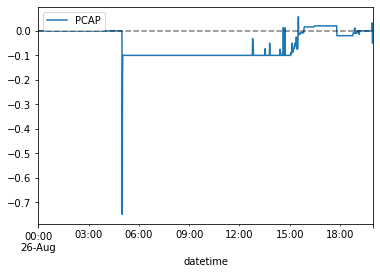

In [86]:
results = {}
for trade_date in sorted(trade_dates):
    results[trade_date] = check_one_day(trade_date, gsym, base_asset, ch_refdata, pcap_ch_table, normal_hours_start_local, normal_hours_end_local)

In [87]:
#r = pd.DataFrame.from_dict(results, orient='index', columns=['incorrect_data_pcap', 'pcap_arbs_over_0', 'pcap_arbs_very_over_0', 'pcap_arbs_over_0_normal_hours', 'pcap_arbs_very_over_0_normal_hours', 'pcap_arbs_over_0_optim_hours', 'pcap_arbs_very_over_0_optim_hours'])
r = pd.DataFrame.from_dict(results, orient='index', columns=['data_len', 'incorrect_data_pcap', 'pcap_arbs_over_0', 'arbs_epoch_after_fees', 'arbs_mm_after_fees'])
r.sort_index()                         

data_len  incorrect_data_pcap  pcap_arbs_over_0  \
2022-08-26    790959                    0               125   

            arbs_epoch_after_fees  arbs_mm_after_fees  
2022-08-26                      3                 125

### Graphing a minute

In [93]:
trade_date = calendar.get_date('20220826', forward=True)
option_chain = get_options(gsym, trade_date, trade_date, False)
expiry_date = np.datetime64(trade_date)
refdata_options = ch_refdata[(ch_refdata.base_asset == base_asset) & (ch_refdata.expiry_date == expiry_date)]
pcap_df = get_market_data(trade_date, refdata_options, base_asset, pcap_ch_table)

Getting market data for 20220826


In [ ]:
#minute = pd.Timestamp('2023-08-02 15:50:00+00:00')
#minute_data = pcap_df.loc[minute]
#minute_data['strike'] = minute_data.apply(lambda row: refdata_options.loc[row.symbol].strike_price, axis=1)
#minute_data['pc'] = minute_data.apply(lambda row: refdata_options.loc[row.symbol].pc, axis=1)

In [ ]:
#ax = minute_data.plot(x='strike', y='ask', kind='scatter')
#ax.axhline(0, ls='--', color='black', alpha=0.5)

In [ ]:
#import seaborn

In [ ]:
#seaborn.scatterplot(data=minute_data, x='strike', y='ask', hue='pc')

### Print one arb

In [96]:
minute = pd.Timestamp('2022-08-26 15:31:00+00:00')
minute_data = pcap_df.loc[minute]
minute_data['strike'] = minute_data.apply(lambda row: refdata_options.loc[row.symbol].strike_price, axis=1)
minute_data['pc'] = minute_data.apply(lambda row: refdata_options.loc[row.symbol].pc, axis=1)
opt_symbols = minute_data.symbol.unique()
pcf = np.array([*list(refdata_options.loc[opt_symbols, 'pc'])])
strikes = np.array([*list(refdata_options.loc[opt_symbols, 'strike_price'])])
#strikes *= 100.0
gross_payoff = create_gross_payoff(strikes, pcf)
minute_data.bid_100 = minute_data.bid
minute_data.ask_100 = minute_data.ask
payoff, buy, sell = arb_uniform(gross_payoff, pcf, minute_data.bid_100.values, minute_data.ask_100.values)
witharb = minute_data.assign(
    buy=buy,
    sell=sell,
    payoff=payoff,
)
witharb[((witharb['buy'] > 0) | (witharb['sell'] > 0)) & (payoff >0) ]

/tmp/ipykernel_1821108/3869529652.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  minute_data['strike'] = minute_data.apply(lambda row: refdata_options.loc[row.symbol].strike_price, axis=1)
/tmp/ipykernel_1821108/3869529652.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  minute_data['pc'] = minute_data.apply(lambda row: refdata_options.loc[row.symbol].pc, axis=1)
/tmp/ipykernel_1821108/3869529652.py:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pa

symbol                 timestamp   ask   bid  \
timestamp                                                                      
2022-08-26 15:31:00+00:00  QN4Q2 C1328 2022-08-26 15:31:00+00:00  0.75  0.20   
2022-08-26 15:31:00+00:00  QN4Q2 C1353 2022-08-26 15:31:00+00:00  0.05   NaN   
2022-08-26 15:31:00+00:00  QN4Q2 C1350 2022-08-26 15:31:00+00:00  0.40  0.25   
2022-08-26 15:31:00+00:00  QN4Q2 C1335 2022-08-26 15:31:00+00:00  0.55  0.05   

                             mid  ask_size  bid_size   strike pc  \
timestamp                                                          
2022-08-26 15:31:00+00:00  0.475     125.0     147.0  13280.0  C   
2022-08-26 15:31:00+00:00    NaN       5.0       0.0  13530.0  C   
2022-08-26 15:31:00+00:00  0.325     125.0       9.0  13500.0  C   
2022-08-26 15:31:00+00:00  0.300     125.0       1.0  13350.0  C   

                                    buy  sell    payoff  
timestamp                                                
2022-08-26 15:31:00+00:00  4.361713e-16   0.0  0.058333  
2022-08-26 15:31:00+00:00  4.166667e-01   0.0  0.058333  
2022-08-26 15:31:00+00:00  0.000000e+00   0.5  0.058333  
2022-08-26 15:31:00+00:00  8.333333e-02   0.0  0.058333

In [ ]:
from datetime import date
trade_date = date(2022, 8, 26)
normal_hours_start_local = normal_hours_start_local.replace(year=trade_date.year, month=trade_date.month, day=trade_date.day)
normal_hours_end_local = normal_hours_end_local.replace(year=trade_date.year, month=trade_date.month, day=trade_date.day)

In [ ]:
option_chain = get_options(gsym, trade_date, trade_date, False)
expiry_date = np.datetime64(trade_date)
refdata_options = ch_refdata[(ch_refdata.base_asset == base_asset) & (ch_refdata.expiry_date == expiry_date)]
pcap_df = get_market_data(trade_date, refdata_options, base_asset, pcap_ch_table)

In [ ]:
times_begin = refdata_options.expiry_timestamp[0].replace(hour=0, minute=0, second=0).tz_localize('UTC')
times_end = refdata_options.expiry_timestamp[0].tz_localize('UTC')      
opt_symbols = refdata_options.symbol.unique()
        
point_values = np.array([*list(refdata_options.loc[opt_symbols, 'point_value'])])
pcf = np.array([*list(refdata_options.loc[opt_symbols, 'pc'])])
strikes = np.array([*list(refdata_options.loc[opt_symbols, 'strike_price'])])
gross_payoff = create_gross_payoff(strikes, pcf)
times = pd.date_range(times_begin, times_end, inclusive='left', freq='1T', name='datetime')
pcap_data = {
     symbol: frame.drop('symbol', axis='columns').set_index('timestamp').reindex(times)
     for symbol, frame in pcap_df.groupby('symbol', sort=False)
}
pcap_results = get_payoffs(pcap_data, opt_symbols, times, pcf, gross_payoff)
results = pd.DataFrame(
      {'PCAP': pcap_results
      }, index=times)
ax = results.plot()
ax.axhline(0, ls='--', color='black', alpha=0.5)

In [ ]:
results_normal_hours = results[(results.index >= normal_hours_start_local) & (results.index <=  normal_hours_end_local)]
#fees = 0.12 / 20
fees = -0.03
results_normal_hours[results_normal_hours.PCAP > fees].PCAP

In [ ]:
results_normal_hours.PCAP.max()

In [ ]:
import rich
def show_arb(timestamp):
    minute = pd.Timestamp(timestamp)
    minute_data = pcap_df.loc[minute]
    minute_data['strike'] = minute_data.apply(lambda row: refdata_options.loc[row.symbol].strike_price, axis=1)
    minute_data['pc'] = minute_data.apply(lambda row: refdata_options.loc[row.symbol].pc, axis=1)
    opt_symbols = minute_data.symbol.unique()
    pcf = np.array([*list(refdata_options.loc[opt_symbols, 'pc'])])
    strikes = np.array([*list(refdata_options.loc[opt_symbols, 'strike_price'])])
    #strikes *= 100.0
    gross_payoff = create_gross_payoff(strikes, pcf)
    minute_data.bid_100 = minute_data.bid
    minute_data.ask_100 = minute_data.ask
    payoff, buy, sell = arb_uniform(gross_payoff, pcf, minute_data.bid_100.values, minute_data.ask_100.values)
    witharb = minute_data.assign(
        buy=buy,
        sell=sell,
        payoff=payoff,
    )
    res = witharb[((witharb['buy'] > 0) | (witharb['sell'] > 0)) & (payoff >0) ]
    res = res[['symbol', 'strike', 'buy', 'sell', 'bid_size', 'bid', 'ask', 'ask_size', 'payoff']]
    res = res.set_index('symbol').sort_values(by='strike', ascending=True)
    
    # Check if arb can really be traded


    rich.print()
    rich.print(timestamp)
    rich.print (res[(res.buy > 0.1) | (res.sell > 0.1)])
    
    
    rich.print (res)

In [ ]:
import warnings
warnings.filterwarnings('ignore')
for idx in results_normal_hours[results_normal_hours.PCAP > fees].index:
    show_arb(idx)
